# Data Preparation

## Load required libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime as dt

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)

NumPy 1.23.5
Pandas 2.0.1
Matplotlib 3.7.1
Seaborn 0.12.2


---
## Load data with pandas

In [4]:
# Load transaction and customer data
transactionData = pd.read_excel('https://github.com/sabirinID/Quantium-Data-Analytics-Virtual-Internship/raw/main/Files/1-Data%20Preparation%20and%20Customer%20Analytics/QVI_transactionData.xlsx')
customerData = pd.read_csv('https://github.com/sabirinID/Quantium-Data-Analytics-Virtual-Internship/raw/main/Files/1-Data%20Preparation%20and%20Customer%20Analytics/QVI_purchase_behaviour.csv')

---
## Data description

### Transaction data

| Feature Name | Description |
|--------------|-------------|
| DATE | Date of the transaction |
| STORE_NBR | Identification number of the store where the transaction took place |
| LYLTY_CARD_NBR | Loyalty card number of the customer |
| TXN_id | Identification number of the transaction |
| PROD_NBR | Identification number of the product |
| PROD_NAME | Name of the product |
| PROD_QTY | Quantity of the product purchased in a single transaction |
| TOT_SALES | Total sales from the transaction |

### Customer data

| Feature Name | Description |
|--------------|-------------|
| LYLTY_CARD_NBR | Loyalty card number of the customer |
| LIFESTAGE | Life stage of the customer |
| PREMIUM_CUSTOMER | Indicates whether the customer is a premium customer or not |

---
## Exploratory data analysis

The first step in any analysis is to first understand the data. Let's take a look
at each of the datasets provided.

### Examining transaction data

In [5]:
transactionData.shape

(264836, 8)

In [6]:
transactionData.columns

Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES'],
      dtype='object')

In [7]:
# # Rename columns
# transactionData.rename(columns={
#     'DATE'          : 'transaction_date',
#     'STORE_NBR'     : 'store_id',
#     'LYLTY_CARD_NBR': 'loyalty_card_id',
#     'TXN_ID'        : 'transaction_id',
#     'PROD_NBR'      : 'product_id',
#     'PROD_NAME'     : 'product_name',
#     'PROD_QTY'      : 'product_quantity',
#     'TOT_SALES'     : 'total_sales'
#     }, inplace=True)

# Look at the first 10 rows
transactionData.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,43604,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,43601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,43601,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,43332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,43330,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


- Let's check if columns we would expect to be numeric are in numeric form and date
columns are in date format.

#### Examine transaction data

In [8]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


- We can see that the `DATE` column is in an integer format. Let's change this to a
date format.
- We should check that we are looking at the right products by examining `PROD_NAME`.

#### Convert `DATE` column to a date format

- A quick search online tells us that CSV and Excel integer dates begin on 30
Dec 1899.

In [9]:
# Convert 'DATE' column to datetime format
transactionData['DATE'] = pd.to_datetime(transactionData['DATE'], origin='1899-12-30', unit='D')

transactionData['DATE'].describe()

count                           264836
mean     2018-12-30 00:52:12.879215616
min                2018-07-01 00:00:00
25%                2018-09-30 00:00:00
50%                2018-12-30 00:00:00
75%                2019-03-31 00:00:00
max                2019-06-30 00:00:00
Name: DATE, dtype: object

#### Examine `PROD_NAME`

In [10]:
transactionData['PROD_NAME'].nunique()

114

In [11]:
transactionData['PROD_NAME'].value_counts(normalize=True).round(5)

PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      0.01248
Kettle Tortilla ChpsHny&Jlpno Chili 150g    0.01245
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    0.01234
Tyrrells Crisps     Ched & Chives 165g      0.01234
Cobs Popd Sea Salt  Chips 110g              0.01233
Kettle 135g Swt Pot Sea Salt                0.01230
Tostitos Splash Of  Lime 175g               0.01228
Infuzions Thai SweetChili PotatoMix 110g    0.01224
Smiths Crnkle Chip  Orgnl Big Bag 380g      0.01221
Thins Potato Chips  Hot & Spicy 175g        0.01219
Kettle Sensations   Camembert & Fig 150g    0.01215
Doritos Corn Chips  Cheese Supreme 170g     0.01215
Pringles Barbeque   134g                    0.01212
Doritos Corn Chip Mexican Jalapeno 150g     0.01210
Kettle Sweet Chilli And Sour Cream 175g     0.01208
Smiths Crinkle Chips Salt & Vinegar 330g    0.01207
Thins Chips Light&  Tangy 175g              0.01204
Dorito Corn Chp     Supreme 380g            0.01203
Pringles Sweet&Spcy BBQ 134g                0.01200
In

- Looks like we are definitely looking at potato chips but how can we check that
these are all chips? We can do some basic text analysis by summarising the
individual words in the product name, `PROD_NAME`.
- Examine the words in `PROD_NAME` to see if there are any incorrect entries such as products that are not chips

In [12]:
# Extract product words
productWords = transactionData['PROD_NAME'].str.split().apply(pd.Series, 1).stack()
productWords.index = productWords.index.droplevel(-1)
productWords.name = 'words'

- As we are only interested in words that will tell us if the product is chips or
not, let's remove all words with digits and special characters such as '&' from our
set of product words.

In [14]:
# Remove all words with digits
productWords = productWords.str.replace(r'\d+', '', regex=True)

# Remove all words with special characters
productWords = productWords.str.replace(r'[^\w\s]', '', regex=True)

# Remove all words that are just empty spaces
productWords = productWords[productWords.str.replace(' ', '').str.isalpha()]

- Let's look at the most common words by counting the number of times a word
appears and sorting them by this frequency in order of highest to lowest frequency.

In [15]:
# Count the frequency of each word
wordCounts = productWords.value_counts().reset_index()
wordCounts.columns = ['words', 'frequency']

# Sort the words by frequency
wordCounts = wordCounts.sort_values(by='frequency', ascending=False)

In [16]:
# Remove all words that are alphabets, conjunctions, and prepositions
wordCounts = wordCounts[~wordCounts['words'].isin(['g', 'G', 'And', 'Of'])]

In [29]:
wordCounts.head(13)

,words,frequency
1,Chips,49770
2,Kettle,41288
3,Smiths,28860
4,Salt,27976
5,Cheese,27890
6,Pringles,25102
7,Doritos,24962
8,Crinkle,23960
9,Corn,22063
10,Original,21560


- There are salsa products in the dataset but we are only interested in the chips
category, so let's remove these.

#### Remove salsa products

In [24]:
# Remove salsa products
transactionData['Salsa'] = transactionData['PROD_NAME'].str.contains('Salsa', case=False)
transactionData = transactionData[~transactionData['Salsa']]
transactionData.drop('Salsa', axis=1, inplace=True)

- Next, we can use `describe()` to check summary statistics such as mean, min and max
values for each feature to see if there are any obvious outliers in the data and if
there are any nulls in any of the columns (`NA's : number of nulls` will appear in
the output if there are any nulls).

In [26]:
transactionData.describe(include='all')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742,246742.000000,246742.000000
unique,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,NaN,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,NaN,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,NaN,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,NaN,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,NaN,200.000000,650.000000


- There are no nulls in the columns but product quantity, `PROD_QTY`, appears to have an outlier which we should investigate further. Let's investigate further the case where 200
packets of chips are bought in one transaction.

#### Filter the dataset to find the outlier

In [27]:
transactionData[transactionData['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


- There are two transactions where 200 packets of chips are bought in one transaction
and both of these transactions were by the same customer.
- Let's see if the customer has had other transactions.

In [28]:
transactionData[transactionData['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


- It looks like this customer has only had the two transactions over the year and is
not an ordinary retail customer. The customer might be buying chips for commercial
purposes instead. We'll remove this loyalty card number from further analysis.

#### Filter out the customer based on the loyalty card number

In [ ]:
transactionData = transactionData[~transactionData['LYLTY_CARD_NBR'] == 226000]

#### Re-examine transaction data

- That's better. Now, let's look at the number of transaction lines over time to see
if there are any obvious data issues such as missing data.

#### Count the number of transactions by `DATE`

In [33]:
transactionData.groupby('DATE')['TXN_ID'].count().shape

(364,)

- There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.

#### Create a sequence of dates and join this the count of transactions by `DATE`

In [61]:
# Create a date range from 1 July 2018 to 30 June 2019
date_range = pd.date_range(start='2018-07-01', end='2019-06-30')

# Convert the date range to a DataFrame
date_df = pd.DataFrame(date_range, columns=['DATE'])

# Set the 'DATE' column as the index
date_df.set_index('DATE', inplace=True)

# Join the 'transactionData' DataFrame with the 'date_df' DataFrame
# using a left join. This will fill in missing days with NaN values.
transaction_date = transactionData.groupby('DATE').size()
transaction_date.name = 'TXN_DATE'
joined_df = date_df.join(transaction_date, how='left')

# Reset the index
joined_df.reset_index(inplace=True)
joined_df.head()

,DATE,TXN_DATE
0,2018-07-01,663.0
1,2018-07-02,650.0
2,2018-07-03,674.0
3,2018-07-04,669.0
4,2018-07-05,660.0


In [63]:
joined_df[joined_df['TXN_DATE'].isna() == True]

,DATE,TXN_DATE
177,2018-12-25,NaN


#### Plot transactions over time

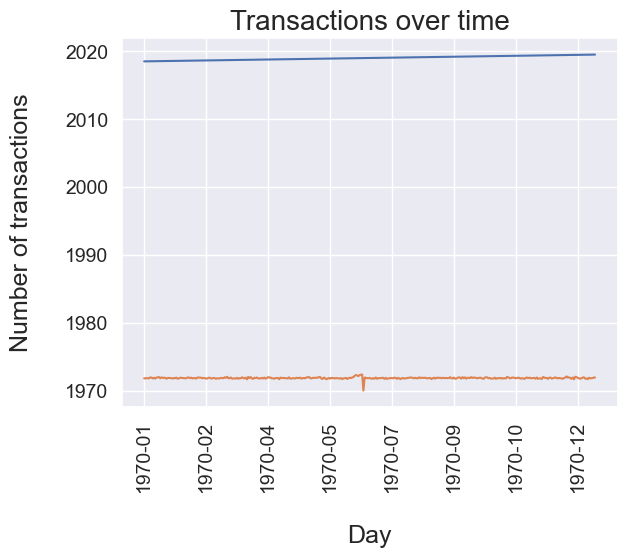

In [50]:
from matplotlib.dates import DateFormatter

transactions_by_day = joined_df.copy()
fig, ax = plt.subplots()
ax.plot(joined_df.index, joined_df.values)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.title('Transactions over time', fontsize=20)
plt.xlabel('\nDay', fontsize=18)
plt.ylabel('Number of transactions\n', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.show()

- We can see that there is an increase in purchases in December and a break in late
December. Let's zoom in on this.

### Customer data

In [18]:
customerData.shape

(72637, 3)

In [19]:
customerData.columns

Index(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER'], dtype='object')

In [20]:
# # Rename columns
# customerData.rename(columns={
#     'LYLTY_CARD_NBR'  : 'loyalty_card_id',
#     'LIFESTAGE'       : 'customer_life_stage',
#     'PREMIUM_CUSTOMER': 'premium_customer'
#     }, inplace=True)

# Look at the first 10 rows
customerData.head(10)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
5,1007,YOUNG SINGLES/COUPLES,Budget
6,1009,NEW FAMILIES,Premium
7,1010,YOUNG SINGLES/COUPLES,Mainstream
8,1011,OLDER SINGLES/COUPLES,Mainstream
9,1012,OLDER FAMILIES,Mainstream


In [21]:
customerData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [22]:
# Merge transactionData and customerData on 'Loyalty_Card_Number'
merged_data = transactionData.merge(customerData, on='LYLTY_CARD_NBR')
merged_data.head(2)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget


In [ ]:
# Plot transactions over time
transactions_by_day = transactionData.groupby('DATE').size()
fig, ax = plt.subplots()
ax.plot(transactions_by_day.index, transactions_by_day.values)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.title('Transactions over time')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.xticks(rotation=90)
plt.show()

# Extract pack size
transactionData['PACK_SIZE'] = transactionData['PROD_NAME'].str.extract("(\d+)").astype(int)

# Rename brand
transactionData['BRAND'].replace('RED', 'RRD', inplace=True)

# Merge transactionData and customer_data
data = pd.merge(transactionData, customer_data, on='Loyalty_Card_Number', how='left')

# Save to CSV
data.to_csv('QVI_data.csv', index=False)